In [17]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import nltk #For POS tagging
import sklearn #For generating some matrices
import pandas as pd#For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #MAkes the plots look nice

import pickle #if you want to save layouts
import os



%matplotlib inline

In [18]:
powOnly = pd.read_csv('D:/contentAnalysis/content-analysis-2018/data/powOnly.csv')

In [19]:
powOnly

,article,date,cluster
0,China said today that growing tension al...,September 23 1980,2
1,China said today that growing tension al...,September 24 1980,2
2,After six hours of talks with Hanoi offi...,December 21 1981,2
3,", Vietnam, Dec. 22 Foreign Minister Nguye...",December 23 1981,2
4,Four American Vietnam veterans walked thro...,December 27 1981,2
5,"The Vietnam War is over, but hostilities c...",December 29 1981,2
6,", N.Y. An American flag waves above the f...",May 29 1981,2
7,"Today, more than 14 years after he was l...",July 24 1981,2
8,To the Editor: With regard to your Dec. 3...,January 25 1982,2
9,", Thailand, Feb. 21 The United States Dep...",February 22 1982,2


In [20]:
powOnly['tokenized_sents'] = powOnly['article'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
powOnly['normalized_sents'] = powOnly['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = None, stemmer = lucem_illud.stemmer_basic) for s in x])

In [21]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

In [22]:
g = wordCooccurrence(powOnly['normalized_sents'].sum())

In [23]:
len(g.nodes)

2741

In [24]:
len(g.edges)

137305

In [25]:
def tokenize(text):
    tokenlist = nltk.word_tokenize(text)
    normalized = lucem_illud.normalizeTokens(tokenlist, stopwordLst = lucem_illud.stop_words_basic) #, stemmer = lucem_illud.stemmer_basic)
    return normalized

In [26]:
powVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)

# let's see what happens when I take the range [:10] our of vects_incidence
# this is apparently a bad idea...

powVects_incidence = powVectorizer.fit_transform(powOnly['article'])

In [27]:
powVects_incidence.shape

(73, 3644)

In [28]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((powVectorizer.get_feature_names()[i] for i in range(powVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(powVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, powVectorizer.get_feature_names()[w], {'weight' : powVects_incidence[d, w]}) for d, w in zip(*powVects_incidence.nonzero())))

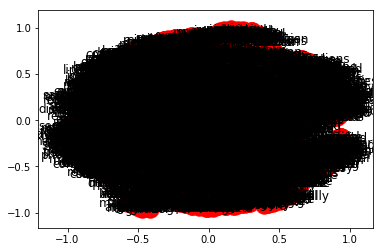

In [29]:
# crazy big
nx.draw_networkx(g_2mode)

In [30]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [31]:
gDoc = contractNetwork(g_2mode, 'doc')

In [32]:
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 73
Number of edges: 2628
Average degree:  72.0000


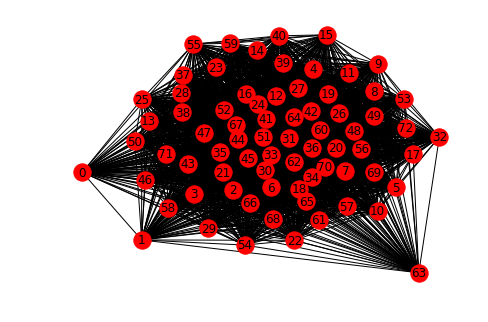

In [33]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

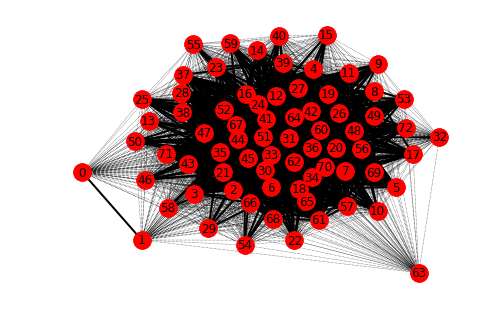

In [34]:

wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

In [42]:
print(powOnly.iloc[63]['article'].strip().replace('  ', '\n'))


Gen. John W. Vessey Jr. is meeting with Vietnamese officials on missing Americans. (U.S. Army) Page 5.
LANGUAGE: ENGLISH
TYPE: CAPTION


In [50]:
print(powOnly.iloc[0]['date'].strip().replace('  ', '\n'))
print(powOnly.iloc[0]['article'].strip().replace('  ', '\n'))

September 23 1980
China said today that growing tension along its border with Vietnam and the deteriorating situation in Indochina had made it impossible to resume peace talks with Hanoi.
The Foreign Ministry said in a statement that a Vietnamese proposal issued on Sept. 12 that the talks, which were broken off in March after eight months of fruitless negotiations, be resumed in Hanoi on Oct. 6 was ''nothing but a trick for propaganda purposes, an attempt to deceive world opinion.''
The Chinese turned down the Hanoi proposal, saying that the Vietnamese are bent on hostility toward China and aggression in Indochina, particularly toward Cambodia. The statement said Hanoi ''does not have the slightest sincerity'' about a negotiated settlement.
LANGUAGE: ENGLISH


In [52]:
print(powOnly.iloc[51]['date'].strip().replace('  ', '\n'))
print(powOnly.iloc[51]['article'].strip().replace('  ', '\n'))

April 12 1986
, Vietnam, April 12
 Hanoi, saying it is disappointed that progress in the search for Americans missing since the Vietnam War has not elicited ''cooperation and good will'' from the United States, has suddenly shifted to a much harsher public stance toward Washington.
The shift, which comes after less than a year of improving relations, raises the possibility that efforts to determine the fate of more than 1,700 Americans still unaccounted for in Vietnam will be halted, according to Hanoi officials.
Recent public statements from Hanoi also indicate that the Vietnamese are becoming alarmed at signs of reinvigorated Thai-American military cooperation and the likelihood that more American support will be given to rebels fighting the Vietnamese-backed Government of Cambodia.
'A U.S. Comeback'
After Defense Secretary Caspar W. Weinberger toured the Cambodian border area last Tuesday while on a visit to Thailand, the Vietnamese News Agency, envisioning what it called ''a U.S. c

In [36]:
gWord = contractNetwork(g_2mode, 'word')
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 3644
Number of edges: 1165280
Average degree: 639.5609


In [37]:
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
wMean

1.4281571811066869

In [38]:
gWord.remove_edges_from([(n1, n2) for n1, n2, d in gWord.edges(data = True) if d['weight'] <= 1])
gWord.remove_nodes_from(list(nx.isolates(gWord))) #since we are changing the graph list() evuluates the isolates first
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 1689
Number of edges: 212017
Average degree: 251.0562


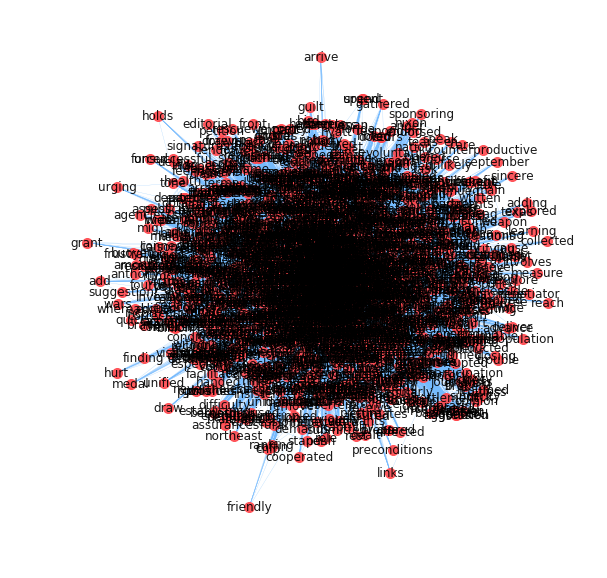

In [39]:
layout = nx.spring_layout(gWord, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gWord, ax = ax, pos = layout, labels = {n:n for n in gWord.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [46]:
minWeight = 20
gWord.remove_edges_from([(n1, n2) for n1, n2, d in gWord.edges(data = True) if d['weight'] <= minWeight])
gWord.remove_nodes_from(list(nx.isolates(gWord))) #since we are changing the graph list() evuluates the isolates first
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 78
Number of edges: 1144
Average degree:  29.3333


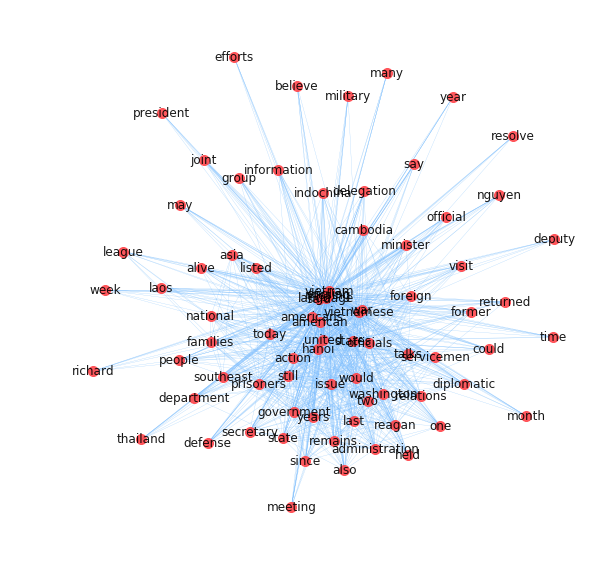

In [47]:
layout = nx.spring_layout(gWord, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gWord, ax = ax, pos = layout, labels = {n:n for n in gWord.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying